In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
import histlib.diagnosis as diag
from histlib.cstes import labels, zarr_dir, matchup_dir, var2, var, c0, c1
from histlib.matchup import _data_var, _stress_var, _aviso_var
from  histlib.diagnosis import global_ms_drifter_sat_year, compute_sum_ms, nMSRe_id, C_x, true_err_x, plot_closure_bar, plot_cor_uncor_part, global_cor

from xhistogram.xarray import histogram


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm


/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## IMPORT DATA, build dataset
We choose to get only erastar wind term, and we reject PEACHY data, and we select only deltaT<1H

In [3]:
np.sqrt(((65/1000)**5)/65*3/4*1e2)

0.0011570639027296634

In [4]:
((65/1000)**5)/65*3/4*1e2

1.3387968750000002e-06

In [2]:
id_aviso = 'aviso__25__adt__es_cstrio_z15__alti_x'
id_aviso_drifter = 'aviso__25__adt__es_cstrio_z15__drifter_x'
id_co = 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x'
id_aviso_drifter_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'aviso_drifter_ggx_adt','wind':'es_cstrio_z15_drifter_wd_x'}
id_co_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wind':'es_cstrio_z15_alti_wd_x'}
id_aviso_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'aviso_alti_ggx_adt','wind':'es_cstrio_z15_alti_wd_x'}

var = list(id_co_dic.values())+list(id_aviso_dic.values())+list(id_aviso_drifter_dic.values())+['nb_coloc_bin']+['sum_'+v for v in [id_aviso, id_co, id_aviso_drifter]]+['sum_'+v for v in [id_aviso, id_co, id_aviso_drifter]]+['exc_acc_'+v for v in [id_aviso, id_co, id_aviso_drifter]]+['exc_coriolis_'+v for v in [id_aviso, id_co, id_aviso_drifter]]+['exc_ggrad_'+v for v in [id_aviso, id_co, id_aviso_drifter]]+['exc_wind_'+v for v in [id_aviso, id_co, id_aviso_drifter]]


In [3]:
dl = 5
dt = 10*60

In [4]:
def put_fig_letter(ax, letter, **kwargs):
    ax.text(0.0, 1.0, letter+')', transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0), **kwargs)

___________
__________
# Distance dependency

In [5]:
files_ms = glob(os.path.join(zarr_dir+'_ok',f'msdist/msdist_{int(dl)}_drogued_*.zarr'))
files_ms = [f for f in files_ms if 'gps' in f]
files_mean = glob(os.path.join(zarr_dir+'_ok',f'meandist/meandist_{int(dl)}_drogued_*.zarr'))
files_mean = [f for f in files_mean if 'gps' in f]
files_corr = glob(os.path.join(zarr_dir+'_ok',f'corrdist/corrdist_{int(dl)}_drogued_*.zarr'))
files_corr = [f for f in files_corr if 'gps' in f]

In [6]:
dsms = xr.open_mfdataset(files_ms)[var].rename({'nb_coloc_bin':'nb_coloc'}).compute()
dsmean = xr.open_mfdataset(files_mean)[var].rename({'nb_coloc_bin':'nb_coloc'}).compute()
dscorr = xr.open_mfdataset(files_corr).rename({'nb_coloc_bin':'nb_coloc'}).compute()

In [7]:
gps = [l for l in dsms.drifter_sat_year.values if 'gps' in l]
dsd, mslow, msup = global_ms_drifter_sat_year(dsmean.sel(drifter_sat_year=gps), dsms.sel(drifter_sat_year=gps), alpha=0.01)
mserr = (msup-mslow)/2

dsdc = -2* global_cor(dscorr)# balanced contribution
dsdc['distbin']=dsdc['distbin']/1000
dsd['distbin']=dsd['distbin']/1000
mserr['distbin']=mserr['distbin']/1000

<xarray.DataArray 'nb_coloc' (distbin: 40)>
array([26942., 30340., 30038., 29228., 29478., 29445., 29489., 29418.,
       29508., 29308., 29247., 29334., 29260., 29317., 29280., 29644.,
       29218., 29475., 29068., 28999., 28999., 28971., 29089., 28765.,
       29272., 29017., 29003., 29146., 29111., 28917., 28833., 28877.,
       28739., 28573., 28926., 28525., 28688., 28692., 28399., 20227.])
Coordinates:
  * distbin  (distbin) float64 2.5e+03 7.5e+03 1.25e+04 ... 1.925e+05 1.975e+05
<xarray.DataArray 'nb_coloc' (distbin: 40)>
array([26942., 30340., 30038., 29228., 29478., 29445., 29489., 29418.,
       29508., 29308., 29247., 29334., 29260., 29317., 29280., 29644.,
       29218., 29475., 29068., 28999., 28999., 28971., 29089., 28765.,
       29272., 29017., 29003., 29146., 29111., 28917., 28833., 28877.,
       28739., 28573., 28926., 28525., 28688., 28692., 28399., 20227.])
Coordinates:
  * distbin  (distbin) float64 2.5e+03 7.5e+03 1.25e+04 ... 1.925e+05 1.975e+05


_____________
# Covariance

In [14]:
def exp_decay(dx, dx_constant, amplitude, cst):
    return np.exp(-dx / dx_constant) * 2e-10*amplitude +cst

cor_alg = dsdc.prod_drifter_coriolis_x_25__alti_ggx_adt_filtered_ocean_tide_internal_tide

acc_alg = dsdc.prod_drifter_acc_x_25__alti_ggx_adt_filtered_ocean_tide_internal_tide
cor_av = dsdc.prod_drifter_coriolis_x_25__aviso_alti_ggx_adt
acc_av = dsdc.prod_drifter_acc_x_25__aviso_alti_ggx_adt
cor_av_d = dsdc.prod_drifter_coriolis_x_25__aviso_drifter_ggx_adt
acc_av_d = dsdc.prod_drifter_acc_x_25__aviso_drifter_ggx_adt
cor_wd_alti = dsdc.prod_drifter_coriolis_x_25__es_cstrio_z15_alti_wd_x
cor_wd_drifter = dsdc.prod_drifter_coriolis_x_25__es_cstrio_z15_drifter_wd_x

fit_cor_alg = cor_alg.curvefit("distbin", exp_decay)
fit_acc_alg = acc_alg.curvefit("distbin", exp_decay)
fit_cor_av = cor_av.curvefit("distbin", exp_decay)
fit_acc_av = acc_av.curvefit("distbin", exp_decay)
fit_cor_wd_alti = cor_wd_alti.curvefit("distbin", exp_decay)

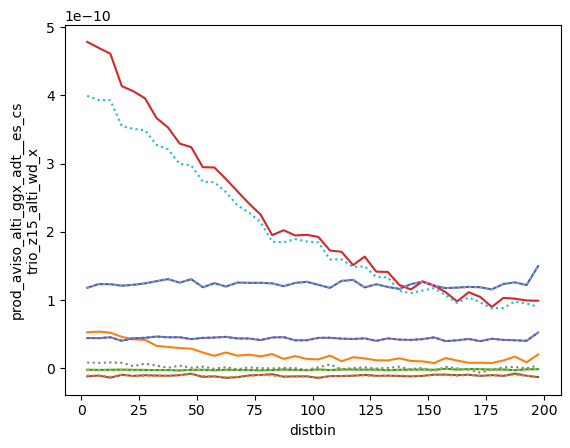

In [15]:
import itertools
corr_key_co = list(itertools.combinations(list(id_co_dic.values()),2))
corr_key_av = list(itertools.combinations(list(id_aviso_dic.values()),2)) 
corr_var_co = ["prod_"+ab[0]+"__"+ab[1] for ab in corr_key_co]
corr_var_aviso = ["prod_"+ab[0]+"__"+ab[1] for ab in corr_key_av]

for v in corr_var_co :
    dsdc[v].plot(label=v)
for v in corr_var_aviso :
    dsdc[v].plot(label=v, ls=':')
#plt.legend()

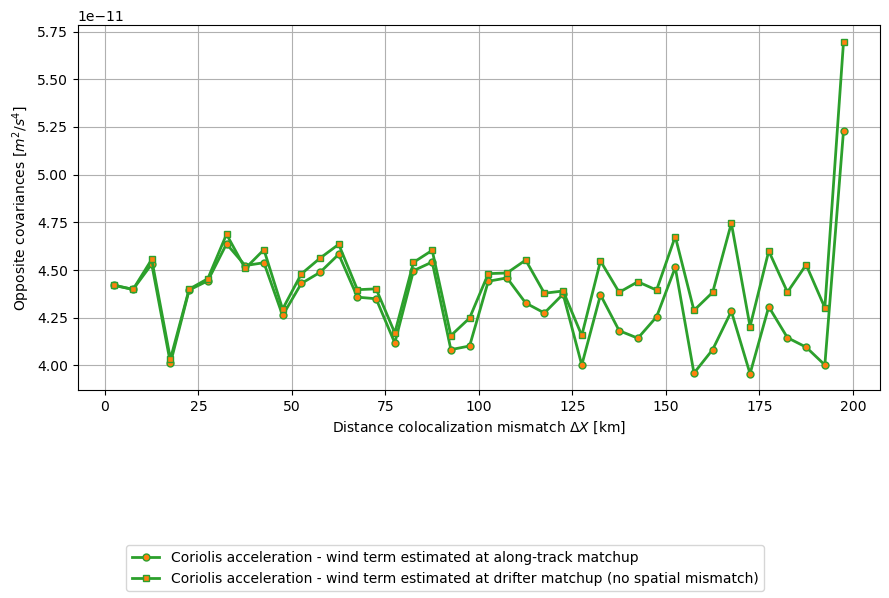

In [10]:
fig, ax = plt.subplots(1,1, figsize=(9,6))

cor_wd_alti.plot(c = c0['coriolis'], marker = 'o', markerfacecolor=c0['wind'], markersize=5, lw=2, label= 'Coriolis acceleration - wind term estimated at along-track matchup')
cor_wd_drifter.plot(c = c0['coriolis'], marker = 's', markerfacecolor=c0['wind'], markersize=5, lw=2, label= 'Coriolis acceleration - wind term estimated at drifter matchup (no spatial mismatch)')

ax.grid()
ax.set_ylabel('Opposite covariances $[m^2/s^4]$')
ax.set_xlabel('Distance colocalization mismatch $\Delta X$ [km]')

fig.legend(ncol=1,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.24,1,1])#left, bottom, right, top (default is 0,0,1,1)

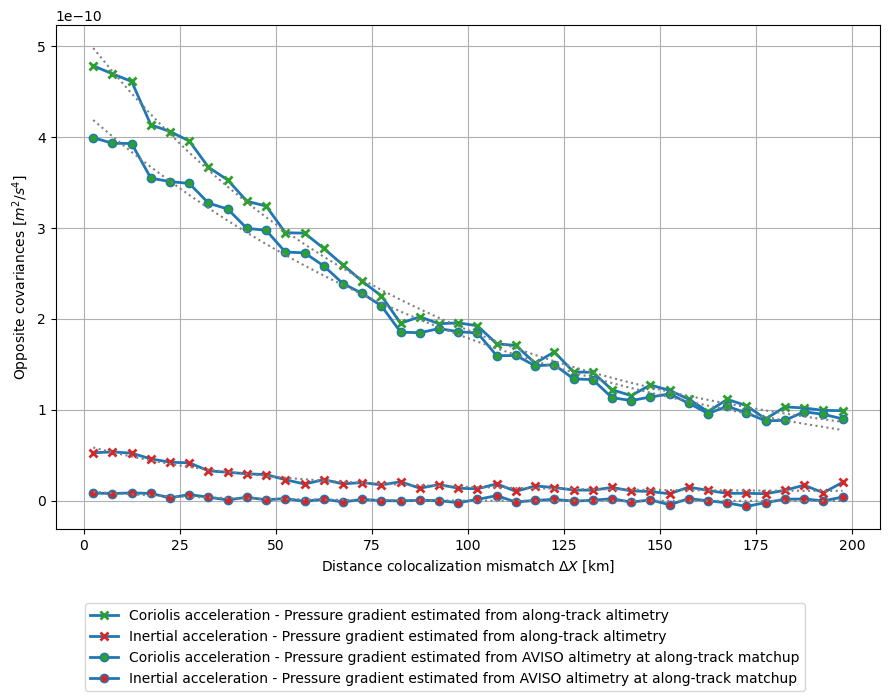

In [11]:
fig, ax = plt.subplots(1,1, figsize=(9,7))

cor_alg.plot(c = c0['ggrad'], marker = 'x', markeredgewidth = 2, markeredgecolor=c0['coriolis'], lw=2, label= 'Coriolis acceleration - Pressure gradient estimated from along-track altimetry')
acc_alg.plot(c = c0['ggrad'], marker = 'x', markeredgewidth = 2, markeredgecolor=c0['acc'],  lw=2, label= 'Inertial acceleration - Pressure gradient estimated from along-track altimetry')
cor_av.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['coriolis'],  lw=2, label= 'Coriolis acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')
acc_av.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['acc'],lw=2, label= 'Inertial acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')


exp_decay(cor_alg.distbin, *fit_cor_alg.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(acc_alg.distbin, *fit_acc_alg.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(cor_av.distbin, *fit_cor_av.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(acc_av.distbin, *fit_acc_av.curvefit_coefficients).plot(ls=':', c='grey')

ax.grid()
ax.set_ylabel('Opposite covariances $[m^2/s^4]$')
ax.set_xlabel('Distance colocalization mismatch $\Delta X$ [km]')
ax.set_title('')

fig.legend(ncol=1,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.15,1,1])#left, bottom, right, top (default is 0,0,1,1)

______________________
# Exponential fit


In [12]:
for da in [fit_cor_alg, fit_acc_alg, fit_cor_av, fit_acc_av, fit_cor_wd_alti]:
    dx = da.sel(param="dx_constant").curvefit_coefficients.values
    errdx = np.sqrt(da.sel(cov_i="dx_constant", cov_j="dx_constant").curvefit_covariance).values
    print(f'{np.rint(dx)} pm {np.ceil(errdx)}')

87.0 pm 5.0
43.0 pm 5.0
113.0 pm 9.0
31.0 pm 10.0
145.0 pm 504.0


_____________
# MS

In [13]:
def compute_sum_ms(ds, id_, dic=None):
    if dic == None :
        dic = ds['sum_'+id_].attrs
    return ds[dic['acc']]+ds[dic['coriolis']]+ds[dic['ggrad']]+ds[dic['wind']]

(1e-10, 5e-10)

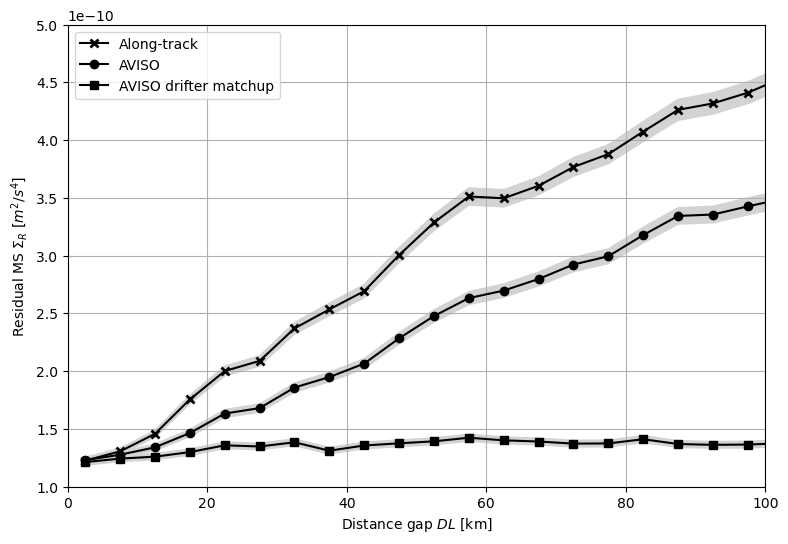

In [16]:
fig, ax = plt.subplots(1,1, figsize=(9,6))
dsd['sum_'+id_co].plot(label='Along-track', ax=ax, c='k', marker='x', markeredgewidth = 2,)
ax.fill_between(dsd.distbin, dsd['sum_'+id_co]-mserr['sum_'+id_co], dsd['sum_'+id_co]+mserr['sum_'+id_co], color='lightgrey')
dsd['sum_'+id_aviso].plot(label='AVISO', ax=ax, c='k', marker='o')
ax.fill_between(dsd.distbin, dsd['sum_'+id_aviso]-mserr['sum_'+id_aviso], dsd['sum_'+id_aviso]+mserr['sum_'+id_aviso], color='lightgrey')
dsd['sum_'+id_aviso_drifter].plot(label='AVISO drifter matchup', ax=ax, c='k', marker='s')
ax.fill_between(dsd.distbin, dsd['sum_'+id_aviso_drifter]-mserr['sum_'+id_aviso_drifter], dsd['sum_'+id_aviso_drifter]+mserr['sum_'+id_aviso_drifter], color='lightgrey')
ax.grid()
ax.legend()
ax.set_xlabel(r'Distance gap $DL$ [km]')
ax.set_ylabel(r'Residual MS $\Sigma_R$ $[m^2/s^4]$')
ax.set_xlim(0,100)
ax.set_ylim(1e-10,5e-10)

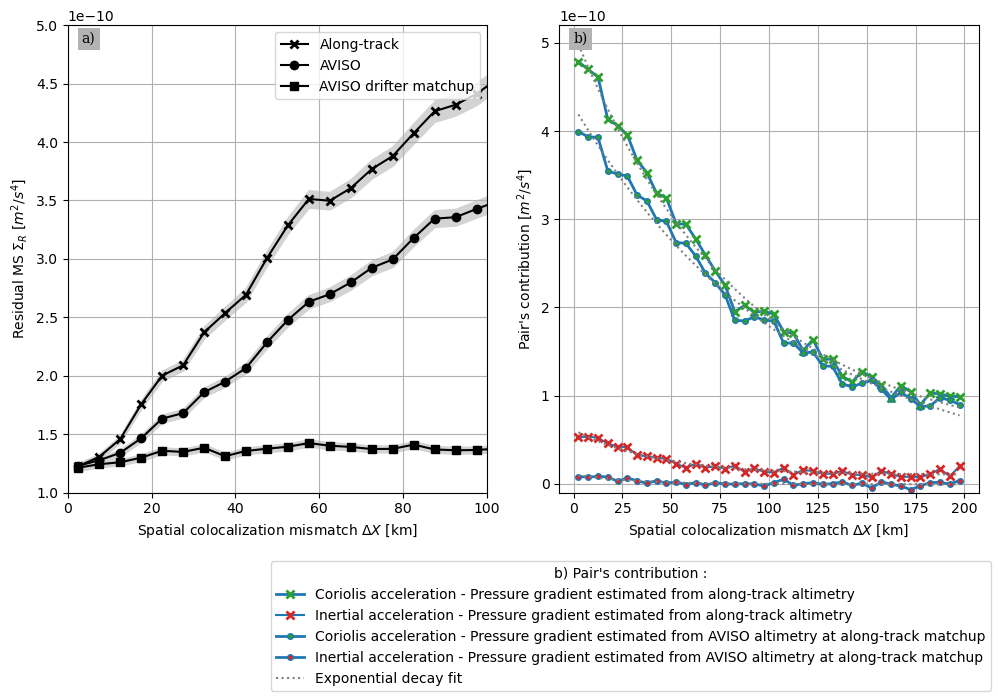

In [17]:
import matplotlib.transforms as mtransforms

fig, axs = plt.subplot_mosaic([['a)', 'b)']],layout='constrained', figsize=(10,7))

for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
    
ax =axs['a)']
dsd['sum_'+id_co].plot(label='Along-track', ax=ax, c='k', marker='x', markeredgewidth = 2,)
dsd['sum_'+id_aviso].plot(label='AVISO', ax=ax, c='k', marker='o')
dsd['sum_'+id_aviso_drifter].plot(label='AVISO drifter matchup', ax=ax, c='k', marker='s')
ax.fill_between(dsd.distbin, dsd['sum_'+id_co]-mserr['sum_'+id_co], dsd['sum_'+id_co]+mserr['sum_'+id_co], color='lightgrey')
ax.fill_between(dsd.distbin, dsd['sum_'+id_aviso]-mserr['sum_'+id_aviso], dsd['sum_'+id_aviso]+mserr['sum_'+id_aviso], color='lightgrey')
ax.fill_between(dsd.distbin, dsd['sum_'+id_aviso_drifter]-mserr['sum_'+id_aviso_drifter], dsd['sum_'+id_aviso_drifter]+mserr['sum_'+id_aviso_drifter], color='lightgrey')

ax.grid()
ax.legend()
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r'Residual MS $\Sigma_R$ $[m^2/s^4]$')
ax.set_xlim(0,100)
ax.set_ylim(1e-10,5e-10)
ax.legend(ncol=1, loc='upper right')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,

ax =axs['b)']
cor_alg.plot(c = c0['ggrad'], marker = 'x', markeredgewidth = 2, markeredgecolor=c0['coriolis'], lw=2, label= 'Coriolis acceleration - Pressure gradient estimated from along-track altimetry')
acc_alg.plot(c = c0['ggrad'], marker = 'x', markeredgewidth = 2, markeredgecolor=c0['acc'], label= 'Inertial acceleration - Pressure gradient estimated from along-track altimetry')
cor_av.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['coriolis'], markersize=4, lw=2, label= 'Coriolis acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')
acc_av.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['acc'], markersize=4, lw=2, label= 'Inertial acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')


exp_decay(cor_alg.distbin, *fit_cor_alg.curvefit_coefficients).plot(ls=':', c='grey', label = 'Exponential decay fit')
exp_decay(acc_alg.distbin, *fit_acc_alg.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(cor_av.distbin, *fit_cor_av.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(acc_av.distbin, *fit_acc_av.curvefit_coefficients).plot(ls=':', c='grey')

ax.grid()
ax.set_title('')
ax.set_ylabel("Pair's contribution $[m^2/s^4]$")
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylim(-1e-11,5.2e-10)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=1,loc='lower right', title="b) Pair's contribution :")#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

In [11]:
sco = compute_sum_ms(dsd, id_co, dic=id_co_dic)
sav = compute_sum_ms(dsd, id_aviso, dic=id_aviso_dic)
savd = compute_sum_ms(dsd, id_aviso_drifter, dic=id_aviso_drifter_dic)

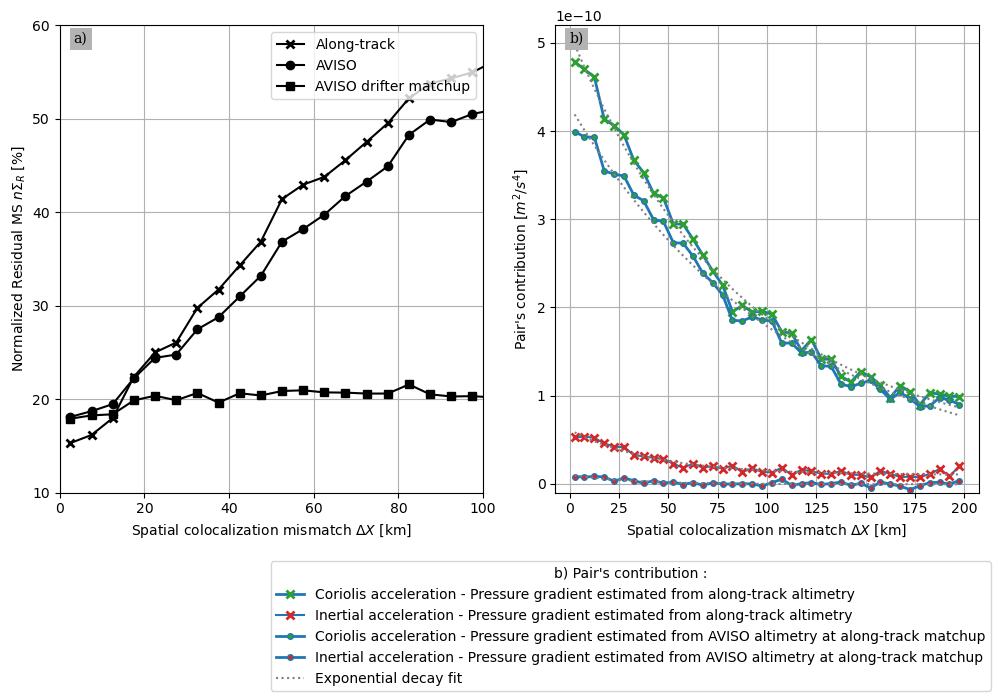

In [24]:
import matplotlib.transforms as mtransforms

fig, axs = plt.subplot_mosaic([['a)', 'b)']],layout='constrained', figsize=(10,7))

for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
    
ax =axs['a)']
(dsd['sum_'+id_co]/sco*100).plot(label='Along-track', ax=ax, c='k', marker='x', markeredgewidth = 2,)
(dsd['sum_'+id_aviso]/sav*100).plot(label='AVISO', ax=ax, c='k', marker='o')
(dsd['sum_'+id_aviso_drifter]/savd*100).plot(label='AVISO drifter matchup', ax=ax, c='k', marker='s')
#ax.fill_between(dsd.distbin, dsd['sum_'+id_co]-mserr['sum_'+id_co], dsd['sum_'+id_co]+mserr['sum_'+id_co], color='lightgrey')
#ax.fill_between(dsd.distbin, dsd['sum_'+id_aviso]-mserr['sum_'+id_aviso], dsd['sum_'+id_aviso]+mserr['sum_'+id_aviso], color='lightgrey')
#ax.fill_between(dsd.distbin, dsd['sum_'+id_aviso_drifter]-mserr['sum_'+id_aviso_drifter], dsd['sum_'+id_aviso_drifter]+mserr['sum_'+id_aviso_drifter], color='lightgrey')

ax.grid()
ax.legend()
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r'Normalized Residual MS $n\Sigma_R$ [%]')
ax.set_xlim(0,100)
ax.set_ylim(10,60)
ax.legend(ncol=1, loc='upper right')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,

ax =axs['b)']
cor_alg.plot(c = c0['ggrad'], marker = 'x', markeredgewidth = 2, markeredgecolor=c0['coriolis'], lw=2, label= 'Coriolis acceleration - Pressure gradient estimated from along-track altimetry')
acc_alg.plot(c = c0['ggrad'], marker = 'x', markeredgewidth = 2, markeredgecolor=c0['acc'], label= 'Inertial acceleration - Pressure gradient estimated from along-track altimetry')
cor_av.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['coriolis'], markersize=4, lw=2, label= 'Coriolis acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')
acc_av.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['acc'], markersize=4, lw=2, label= 'Inertial acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')


exp_decay(cor_alg.distbin, *fit_cor_alg.curvefit_coefficients).plot(ls=':', c='grey', label = 'Exponential decay fit')
exp_decay(acc_alg.distbin, *fit_acc_alg.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(cor_av.distbin, *fit_cor_av.curvefit_coefficients).plot(ls=':', c='grey')
exp_decay(acc_av.distbin, *fit_acc_av.curvefit_coefficients).plot(ls=':', c='grey')

ax.grid()
ax.set_title('')
ax.set_ylabel("Pair's contribution $[m^2/s^4]$")
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylim(-1e-11,5.2e-10)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=1,loc='lower right', title="b) Pair's contribution :")#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

_______
# Captured vs errors parts

In [46]:
def true_err_x(ds_, id_, dic) :
    dso = xr.Dataset()
    dso['S'] = ds_['sum_'+id_]
    for x in ['acc', 'coriolis', 'ggrad', 'wind']:
        X =dic[x]
        dso[x] = ds_[X]
        dso['exc_'+x] = ds_['exc_' + x +'_'+ id_]
        dso['true_'+x] = (ds_[X] - ds_['sum_'+id_] + ds_['exc_' + x +'_'+ id_])/2
        dso['err_'+x] = (ds_[X] + ds_['sum_'+id_] - ds_['exc_' + x +'_'+ id_])/2
        
    dso['sum_x']=dso['acc']+dso['coriolis']+dso['ggrad']+dso['wind']
    dso['sum_truex']=dso['true_acc']+dso['true_coriolis']+dso['true_ggrad']+dso['true_wind']
    dso['sum_errx']=dso['err_acc']+dso['err_coriolis']+dso['err_ggrad']+dso['err_wind']
    return dso
    
dsdt = xr.concat([true_err_x(dsd, id_co, id_co_dic), true_err_x(dsd, id_aviso, id_aviso_dic)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))

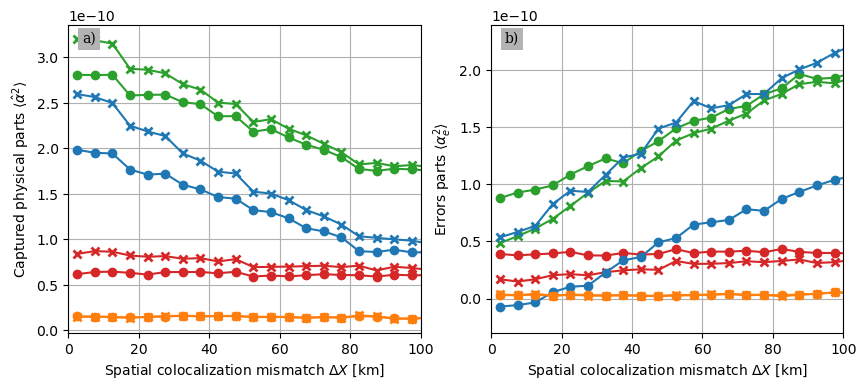

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
ax = axs[0]
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    dsdt.sel(id_comb=id_co)['true_'+v].plot(label='Along Track ' +v, color = c0[v], marker='x',markeredgewidth = 2, ax=ax)
    dsdt.sel(id_comb=id_aviso)['true_'+v].plot(label='AVISO ' +v, color = c0[v], marker='o', ax=ax)
#ax.legend(ncol = 2, bbox_to_anchor=(0, -0.7), loc='lower left')
ax.grid()
ax.set_xlim(0,100)
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r'Captured physical parts $\langle \hat{\alpha}^2 \rangle$')
ax.set_title('')
put_fig_letter(ax, 'a')

ax = axs[1]
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    dsdt.sel(id_comb=id_co)['err_'+v].plot(label='Along Track ' +v, color = c0[v], marker='x',markeredgewidth = 2, ax=ax)
    dsdt.sel(id_comb=id_aviso)['err_'+v].plot(label='AVISO ' +v, color = c0[v], marker='o', ax=ax)
#ax.legend(ncol = 2, bbox_to_anchor=(0, -0.7), loc='lower left')
ax.grid()
ax.set_xlim(0,100)
ax.set_ylim(-3e-11,2.4e-10)
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r'Errors parts $\langle \alpha_e^2 \rangle$')
ax.set_title('')
put_fig_letter(ax, 'b')

______________________
# Spatial Colocalization error estimation


In [56]:
## IMPORT GLOBAL MS ESTIMATION
DL =25*1e3 #meters
DT = 1800.0 #seconds
dsms = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'ms_{int(DL//1000)}_{DT}_drogued.zarr'))
gps = [l for l in dsms.drifter_sat_year.values if 'gps' in l]
dsmean = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'mean_{int(DL//1000)}_{DT}_drogued.zarr'))

ds, mslow, msup = global_ms_drifter_sat_year(dsmean.sel(drifter_sat_year=gps), dsms.sel(drifter_sat_year=gps), alpha=0.01)
mserr = (msup-mslow)/2

dste = true_err_x(ds, id_co, id_co_dic)

<xarray.DataArray 'nb_coloc' ()>
array(146030)


In [57]:
print('Along-track : msre25km-mindistmsre/msre25km = ',((ds['sum_'+id_co]-dsd['sum_'+id_co].isel(distbin=0))/ds['sum_'+id_co]*100).values)
print('AVISO : msre25km-mindistmsre/msre25km = ',((ds['sum_'+id_aviso]-dsd['sum_'+id_aviso].isel(distbin=0))/ds['sum_'+id_aviso]*100).values)

Along-track : msre25km-mindistmsre/msre25km =  21.04026192165972
AVISO : msre25km-mindistmsre/msre25km =  11.584476413387163


In [20]:
print('Along-track : msre25km-mindistmsre = ',(ds['sum_'+id_co]-dsd['sum_'+id_co].isel(distbin=0)).values)
print('AVISO : msre25km-mindistmsre = ',(ds['sum_'+id_aviso]-dsd['sum_'+id_aviso].isel(distbin=0)).values)

Along-track : msre25km-mindistmsre =  3.267745859702327e-11
AVISO : msre25km-mindistmsre =  1.6115257908045492e-11


In [21]:
dste[[v for v in dste if 'err_' in v]]

<xarray.Dataset>
Dimensions:       ()
Data variables:
    err_acc       float64 1.807e-11
    err_coriolis  float64 6.326e-11
    err_ggrad     float64 7.072e-11
    err_wind      float64 3.255e-12

In [22]:
dsdt.sel(id_comb=id_co).isel(distbin=slice(0,3))[[v for v in dste if 'err_' in v]]

<xarray.Dataset>
Dimensions:       (distbin: 3)
Coordinates:
  * distbin       (distbin) float64 2.5 7.5 12.5
    id_comb       <U68 'co__25__adt_filtered_ocean_tide_internal_tide__es_cst...
Data variables:
    err_acc       (distbin) float64 1.688e-11 1.488e-11 1.684e-11
    err_coriolis  (distbin) float64 4.852e-11 5.462e-11 6.13e-11
    err_ggrad     (distbin) float64 5.36e-11 5.831e-11 6.36e-11
    err_wind      (distbin) float64 3.631e-12 2.802e-12 4.072e-12

In [23]:
(dste-dsdt.sel(id_comb=id_co).isel(distbin=slice(0,1)).mean(dim='distbin'))[[v for v in dste if 'err_' in v]]

<xarray.Dataset>
Dimensions:       ()
Coordinates:
    id_comb       <U68 'co__25__adt_filtered_ocean_tide_internal_tide__es_cst...
Data variables:
    err_acc       float64 1.182e-12
    err_coriolis  float64 1.475e-11
    err_ggrad     float64 1.713e-11
    err_wind      float64 -3.756e-13

In [24]:
(dste-dsdt.sel(id_comb=id_co).isel(distbin=slice(0,1)).mean(dim='distbin'))/dste[[v for v in dste if 'err_' in v]]*100 #percentage of colocalization error

<xarray.Dataset>
Dimensions:       ()
Coordinates:
    id_comb       <U68 'co__25__adt_filtered_ocean_tide_internal_tide__es_cst...
Data variables:
    err_acc       float64 6.541
    err_coriolis  float64 23.31
    err_ggrad     float64 24.21
    err_wind      float64 -11.54

In [25]:
(dste-dsdt.sel(id_comb=id_co).isel(distbin=0))/dste[[v for v in dste if 'err_' in v]]*100

<xarray.Dataset>
Dimensions:       ()
Coordinates:
    distbin       float64 2.5
    id_comb       <U68 'co__25__adt_filtered_ocean_tide_internal_tide__es_cst...
Data variables:
    err_acc       float64 6.541
    err_coriolis  float64 23.31
    err_ggrad     float64 24.21
    err_wind      float64 -11.54

In [26]:
dste-dsdt.sel(id_comb=id_co).isel(distbin=0)

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    distbin        float64 2.5
    id_comb        <U68 'co__25__adt_filtered_ocean_tide_internal_tide__es_cs...
Data variables: (12/20)
    S              float64 3.268e-11
    acc            float64 1.359e-12
    exc_acc        float64 3.167e-11
    true_acc       float64 1.775e-13
    err_acc        float64 1.182e-12
    coriolis       float64 -1.81e-13
    ...             ...
    exc_wind       float64 3.289e-11
    true_wind      float64 -1.627e-13
    err_wind       float64 -3.756e-13
    sum_x          float64 -1.506e-13
    sum_truex      float64 -3.283e-11
    sum_errx       float64 3.268e-11

_______________________
________
# Time


In [31]:
dt=60

In [25]:
files_ms = glob(os.path.join(zarr_dir+'_ok',f'mstime/mstime_{int(dt)}_drogued_*.zarr'))
files_ms = [f for f in files_ms if 'gps' in f]
files_mean = glob(os.path.join(zarr_dir+'_ok',f'meantime/meantime_{int(dt)}_drogued_*.zarr'))
files_mean = [f for f in files_mean if 'gps' in f]
files_corr = glob(os.path.join(zarr_dir+'_ok',f'corrtime/corrtime_{int(dt)}_drogued_*.zarr'))
files_corr = [f for f in files_corr if 'gps' in f]

In [30]:
dsms

<xarray.Dataset>
Dimensions:                                                                            (
                                                                                        drifter_sat_year: 40,
                                                                                        timebin: 18)
Coordinates:
  * drifter_sat_year                                                                   (drifter_sat_year) <U21 ...
  * timebin                                                                            (timebin) float64 ...
Data variables: (12/23)
    drifter_acc_x_25                                                                   (drifter_sat_year, timebin) float64 ...
    drifter_coriolis_x_25                                                              (drifter_sat_year, timebin) float64 ...
    alti_ggx_adt_filtered_ocean_tide_internal_tide                                     (drifter_sat_year, timebin) float64 ...
    es_cstrio_z15_alti_wd_x                                                            (drifter_sat_year, timebin) float64 ...
    aviso_alti_ggx_adt                                                                 (drifter_sat_year, timebin) float64 ...
    aviso_drifter_ggx_adt                                                              (drifter_sat_year, timebin) float64 ...
    ...                                                                                 ...
    exc_ggrad_aviso__25__adt__es_cstrio_z15__alti_x                                    (drifter_sat_year, timebin) float64 ...
    exc_ggrad_co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x     (drifter_sat_year, timebin) float64 ...
    exc_ggrad_aviso__25__adt__es_cstrio_z15__drifter_x                                 (drifter_sat_year, timebin) float64 ...
    exc_wind_aviso__25__adt__es_cstrio_z15__alti_x                                     (drifter_sat_year, timebin) float64 ...
    exc_wind_co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x      (drifter_sat_year, timebin) float64 ...
    exc_wind_aviso__25__adt__es_cstrio_z15__drifter_x                                  (drifter_sat_year, timebin) float64 ...

In [28]:
dsms = xr.open_mfdataset(files_ms)[var].rename({'nb_coloc_bin':'nb_coloc'}).compute()
dsmean = xr.open_mfdataset(files_mean)[var].rename({'nb_coloc_bin':'nb_coloc'}).compute()
#dscorr = xr.open_mfdataset(files_corr).rename({'nb_coloc_bin':'nb_coloc'}).compute()

In [29]:
gps = [l for l in dsms.drifter_sat_year.values if 'gps' in l]
dst, mslow, msup = global_ms_drifter_sat_year(dsmean.sel(drifter_sat_year=gps), dsms.sel(drifter_sat_year=gps), alpha=0.01)
mserrt = (msup-mslow)/2

dstc = -2* global_cor(dscorr)# balanced contribution
dstc['timebin']=dstc['timebin']/3600
dst['timebin']=dst['timebin']/3600
mserrt['timebin']=mserrt['timebin']/3600

<xarray.DataArray 'nb_coloc' (timebin: 18)>
array([5.1075e+04, 4.8401e+04, 4.6553e+04, 3.3000e+01, 2.4000e+01,
       3.1000e+01, 2.6000e+01, 2.9000e+01, 2.4000e+01, 2.1000e+01,
       2.7000e+01, 2.6000e+01, 3.3000e+01, 2.2000e+01, 2.9000e+01,
       2.2000e+01, 1.9000e+01, 2.9000e+01])
Coordinates:
  * timebin  (timebin) float64 300.0 900.0 1.5e+03 ... 9.3e+03 9.9e+03 1.05e+04
<xarray.DataArray 'nb_coloc' (distbin: 40)>
array([26942., 30340., 30038., 29228., 29478., 29445., 29489., 29418.,
       29508., 29308., 29247., 29334., 29260., 29317., 29280., 29644.,
       29218., 29475., 29068., 28999., 28999., 28971., 29089., 28765.,
       29272., 29017., 29003., 29146., 29111., 28917., 28833., 28877.,
       28739., 28573., 28926., 28525., 28688., 28692., 28399., 20227.])
Coordinates:
  * distbin  (distbin) float64 2.5e+03 7.5e+03 1.25e+04 ... 1.925e+05 1.975e+05


KeyError: 'timebin'

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
dst['sum_'+id_co].plot(label='Along-track', ax=ax, c='k', marker='x', markeredgewidth=2)
ax.fill_between(dst.timebin, dst['sum_'+id_co]-mserrt['sum_'+id_co], dst['sum_'+id_co]+mserrt['sum_'+id_co], color='lightgrey')
dst['sum_'+id_aviso].plot(label='AVISO', ax=ax, c='k', marker='o')
ax.fill_between(dst.timebin, dst['sum_'+id_aviso]-mserrt['sum_'+id_aviso], dst['sum_'+id_aviso]+mserrt['sum_'+id_aviso], color='lightgrey')
dst['sum_'+id_aviso_drifter].plot(label='AVISO drifter matchup', ax=ax, c='k', marker='s')
ax.fill_between(dst.timebin, dst['sum_'+id_aviso_drifter]-mserrt['sum_'+id_aviso_drifter], dst['sum_'+id_aviso_drifter]+mserrt['sum_'+id_aviso_drifter], color='lightgrey')
ax.grid()
ax.legend()
ax.set_xlabel(r'Time colocalization mismatch $\Delta T$ [h]')
ax.set_ylabel(r'$\Sigma_R$ $[m^2/s^4]$')
ax.set_xlim(0,1)
ax.set_ylim(-1e-10,1.2e-9)

______________________
# Count


In [31]:
dsd.nb_coloc

<xarray.DataArray 'nb_coloc' (distbin: 40)>
array([26942., 30340., 30038., 29228., 29478., 29445., 29489., 29418.,
       29508., 29308., 29247., 29334., 29260., 29317., 29280., 29644.,
       29218., 29475., 29068., 28999., 28999., 28971., 29089., 28765.,
       29272., 29017., 29003., 29146., 29111., 28917., 28833., 28877.,
       28739., 28573., 28926., 28525., 28688., 28692., 28399., 20227.])
Coordinates:
  * distbin  (distbin) float64 2.5 7.5 12.5 17.5 ... 182.5 187.5 192.5 197.5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


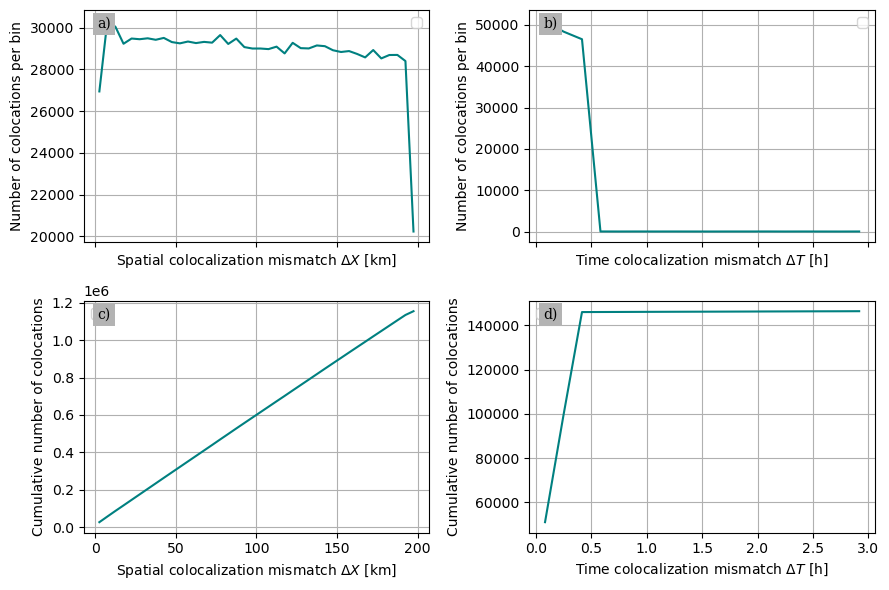

In [32]:
fig, axs = plt.subplots(2,2, figsize=(9,6), sharex='col')
axs = axs.flatten()
ax = axs[0]
dsd.nb_coloc.plot(ax=ax, c='teal')
ax.legend()
ax.grid()
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel('Number of colocations per bin')
put_fig_letter(ax, 'a')

ax = axs[1]
dst.nb_coloc.plot(ax=ax, c='teal')
ax.legend()
ax.grid()
ax.set_xlabel(r'Time colocalization mismatch $\Delta T$ [h]')
ax.set_ylabel('Number of colocations per bin')
put_fig_letter(ax, 'b')

ax = axs[2]
dsd.nb_coloc.cumsum('distbin').plot(ax=ax, c='teal')
ax.legend()
ax.grid()
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel('Cumulative number of colocations')
put_fig_letter(ax, 'c', zorder=10)

ax = axs[3]
dst.nb_coloc.cumsum('timebin').plot(ax=ax, c='teal')
ax.legend()
ax.grid()
ax.set_xlabel(r'Time colocalization mismatch $\Delta T$ [h]')
ax.set_ylabel('Cumulative number of colocations')
put_fig_letter(ax, 'd', zorder=10)

fig.tight_layout()


______________________
# OLD
___________
___________

# $x$ contribution : $C_{x_i} =\langle S_{-x_i}^2\rangle-\langle S^2 \rangle$  and $Rcn_{x_i} = \frac{\langle S_{-x_i}^2\rangle-\langle S^2 \rangle}{\sum_i \langle x_i^2 \rangle}$
## Under H1 :
$Rc_{x_i} = \frac{\langle \hat{x}^2 \rangle - \langle {x_i^{e}}^2\rangle}{\sum_i \langle x_i^2 \rangle}$  

 - $RC_{x_i}<0 \Leftrightarrow \langle \hat{x}^2 \rangle < \langle {x_i^{e}}^2\rangle$ more error than signal is added
 - $RC_{x_i}>0 \Leftrightarrow \langle \hat{x}^2 \rangle > \langle {x_i^{e}}^2\rangle$ more signal than error is added
 - The bigger $Rc_x$ is, the better closure we have
Results :
 - $RC_x$<0 for inertial acceleration and wind

In [33]:
def RC_x(ds, id_, dic=None):
    if isinstance(id_, str):
        lab = ['acc', 'coriolis', 'ggrad', 'wind']
        Rc_x = xr.Dataset()
        for l in lab :
            Rc_x[l] = (ds['exc_'+l+'_'+id_] - ds['sum_'+id_])
    return Rc_x
    
def RCn_x(ds, id_, dic=None):
    if isinstance(id_, str):
        lab = ['acc', 'coriolis', 'ggrad', 'wind']
        s = compute_sum_ms(ds, id_, dic)
        Rcn_x = xr.Dataset()
        for l in lab :
            Rcn_x[l] = (ds['exc_'+l+'_'+id_] - ds['sum_'+id_])/s
    return Rcn_x
    
RCXnd = xr.concat([RCn_x(dsd, id_co, dic = id_co_dic), RCn_x(dsd, id_aviso, dic = id_aviso_dic)], dim =pd.Index([id_co, id_aviso], name='id_comb')) 
#RCXnt = xr.concat([RCn_x(dst, id_co, dic = id_co_dic), RCn_x(dst, id_aviso, dic = id_aviso_dic)], dim =pd.Index([id_co, id_aviso], name='id_comb'))

RCXd = xr.concat([RC_x(dsd, id_co, dic = id_co_dic), RC_x(dsd, id_aviso, dic = id_aviso_dic)], dim =pd.Index([id_co, id_aviso], name='id_comb')) 
#RCXt = xr.concat([RC_x(dst, id_co, dic = id_co_dic), RC_x(dst, id_aviso, dic = id_aviso_dic)], dim =pd.Index([id_co, id_aviso], name='id_comb')) 

In [34]:

plt.figure(figsize=(6,3))
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    RCXnd.sel(id_comb=id_co)[v].plot(label='Along Track ' +v, color = term_color[v])
    RCXnd.sel(id_comb=id_aviso)[v].plot(label='AVISO ' +v, color = term_color[v], ls='--')
plt.legend(ncol = 2, bbox_to_anchor=(0, -0.7), loc='lower left')
plt.grid()
plt.xlabel(r'Distance gap $DL$ [km]')
plt.ylabel(r'$RC_{x_i}$')
plt.title('')


NameError: name 'term_color' is not defined

<Figure size 600x300 with 0 Axes>

In [ ]:

plt.figure(figsize=(6,3))
for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    RCXd.sel(id_comb=id_co)[v].plot(label='Along Track ' +v, color = term_color[v])
    RCXd.sel(id_comb=id_aviso)[v].plot(label='AVISO ' +v, color = term_color[v], ls='--')
plt.legend(ncol = 2, bbox_to_anchor=(0, -0.65), loc='lower left')
plt.grid()
plt.xlabel(r'Distance gap $DL$ [km]')
plt.ylabel(r'$C_{x}$ $[m^2/s^4]$')
plt.title('')
